### Prob 1.

In [14]:
import torch
from torch import nn

def sigma(x):
    return torch.sigmoid(x)
def sigma_prime(x):
    return sigma(x)*(1-sigma(x))


torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))

The weights of the neural network are initialized as above

In [15]:
#forward pass
y_list = [X_data]
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    y_list.append(y)
    
#backward pass
dA_list = []
db_list = []
dy = y-Y_data  # dloss/dy_L
for ell in reversed(range(L)):
    S = sigma_prime if ell<L-1 else lambda x: torch.ones(x.shape)
    A, b, y = A_list[ell], b_list[ell], y_list[ell]

    db = dy*S(A@y+b).T
    dA = S(A@y+b)*dy.T@y.T
    dy = db@A
    
    dA_list.insert(0, dA)
    db_list.insert(0, db)

print(dA_list[0])
print(db_list[0])

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])
tensor([[4.8247e-05, 6.8722e-05, 4.9245e-05, 4.0678e-05]])


The Jacobians are calculated using the chain rule. Also the shape of the Jacobians are implemented to follow the mathematical convention. When we actually use gradient descent, the transpose should be applied to the Jacobian. Note that elementwise multiplication is used to implement the diag(v) matrix. This is much efficient than building the actual diagonal matrix.

In [16]:
for A in A_list:
    A.requires_grad = True
for b in b_list:
    b.requires_grad = True
    
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    
# backward pass in pytorch
loss=torch.square(y-Y_data)/2
loss.backward()

print(A_list[0].grad)
print(b_list[0].grad)

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])
tensor([[4.8247e-05],
        [6.8722e-05],
        [4.9245e-05],
        [4.0678e-05]])


In [17]:
class MLP(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(4,4) for _ in range(L-1)])
        self.linear.append(nn.Linear(4,1))
        for ell in range(L):
            self.linear[ell].weight.data = A_list[ell]
            self.linear[ell].bias.data = b_list[ell].squeeze()
        
    def forward(self, x) :
        x = x.squeeze()
        for ell in range(L-1):
            x = sigma(self.linear[ell](x))
        x = self.linear[-1](x)
        return x

model = MLP()
            
loss = torch.square(model(X_data)-Y_data)/2
loss.backward()

print(model.linear[0].weight.grad)
print(model.linear[0].bias.grad)

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])
tensor([4.8247e-05, 6.8722e-05, 4.9245e-05, 4.0678e-05])


The above two methods are the true gradients, and we can see that the gradients are identical with the method that was implemented.

### Prob 6.

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_class=10):
        super(AlexNet, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6400, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = torch.flatten(output, 1)
        output = self.fc_layer1(output)
        return output

In [10]:
import matplotlib.pyplot as plt
import time

learning_rate = 0.1
batch_size = 64
epochs = 150

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

# Reduce the training data to 10%
trainset_size = int(len(trainset) * 0.1)
indices = torch.randperm(len(trainset)).tolist()
reduced_trainset = torch.utils.data.Subset(trainset, indices[:trainset_size])

# Assign random labels to the reduced dataset
random_labels = torch.randint(0, 10, (trainset_size,))
for i, idx in enumerate(indices[:trainset_size]):
    reduced_trainset.dataset.targets[idx] = random_labels[i]

# Create data loader for the reduced training set
train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=batch_size, shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

accuracy_per_epoch = []
loss_per_epoch = []

tick = time.time()
for epoch in range(150):
    print(f"\nEpoch {epoch + 1} / {epochs}")
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = loss_function(model(images), labels)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    print(f"Loss: {train_loss}")
    loss_per_epoch.append(train_loss)
        
    model.eval()
    #calculate accuracy
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Accuracy: {correct / total}")
    accuracy_per_epoch.append(correct / total)

tock = time.time()
print(f"Total training time: {tock - tick}")


Epoch 1 / 150
Loss: 2.3029802479642503
Accuracy: 0.10583333333333333

Epoch 2 / 150
Loss: 2.3026357356538165
Accuracy: 0.1055

Epoch 3 / 150
Loss: 2.302729063845695
Accuracy: 0.10583333333333333

Epoch 4 / 150
Loss: 2.3025092444521316
Accuracy: 0.10583333333333333

Epoch 5 / 150
Loss: 2.3024768626436276
Accuracy: 0.10583333333333333

Epoch 6 / 150
Loss: 2.3025712611827442
Accuracy: 0.10583333333333333

Epoch 7 / 150
Loss: 2.3024648630872684
Accuracy: 0.1055

Epoch 8 / 150
Loss: 2.3025027893959207
Accuracy: 0.1055

Epoch 9 / 150
Loss: 2.3025264739990234
Accuracy: 0.10583333333333333

Epoch 10 / 150
Loss: 2.302397778693666
Accuracy: 0.1055

Epoch 11 / 150
Loss: 2.3023282695323863
Accuracy: 0.10583333333333333

Epoch 12 / 150
Loss: 2.302452746857988
Accuracy: 0.10583333333333333

Epoch 13 / 150
Loss: 2.302280900326181
Accuracy: 0.10583333333333333

Epoch 14 / 150
Loss: 2.302350143168835
Accuracy: 0.10616666666666667

Epoch 15 / 150
Loss: 2.3022866375902864
Accuracy: 0.10583333333333333



The training code is written as above. 10% of the data are used as training data, and the train_loss is calculated for every epoch and the model evaluates the train data every epoch. The accuray values and train_loss values are stored for later visualization.

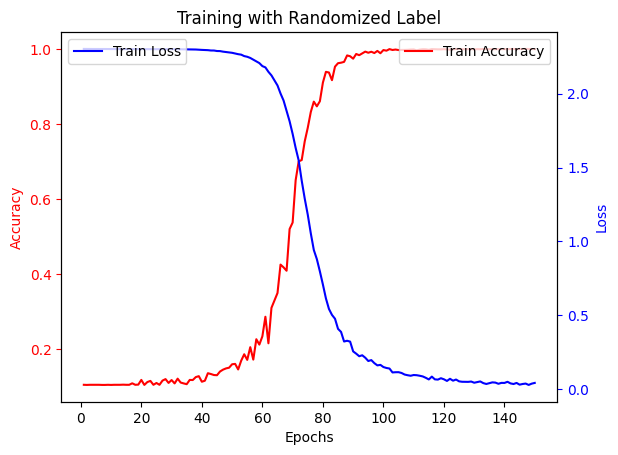

In [13]:
epochs = range(1, 151)
fig, ax1 = plt.subplots()

# Plot the accuracy data in red on the first Axes
ax1.plot(epochs, accuracy_per_epoch, 'r-', label='Train Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='r')
ax1.tick_params('y', colors='r')

# Set the title of the graph
plt.title('Training with Randomized Label')

# Create a second Axes for the loss data, sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(epochs, loss_per_epoch, 'b-', label='Train Loss')
ax2.set_ylabel('Loss', color='b')
ax2.tick_params('y', colors='b')

# Optionally add a legend
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')

# Show the plot
plt.show()

This graph shows that even with radom labels, the nueral network can memorize the label within some point of training